In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ------------------------------------------------------------------
# 1. Signal Specifications
# ------------------------------------------------------------------
fs = 100e6              # Sampling rate: 100 MHz
f1 = 12.5e6             # Sine wave 1: 12.5 MHz
f2 = 25e6             # Sine wave 2: 25 MHz
amp = 50               # Amplitude
fft_size = 256          # FFT points
num_packets = 1        # Number of packets to concatenate
total_samples = fft_size * num_packets

In [3]:
# ------------------------------------------------------------------
# 2. Generate Time Domain Signal
# ------------------------------------------------------------------
# Generate time vector for the total duration (10 packets)
t = np.arange(total_samples) / fs

# Create the signal: Sum of two sine waves
# x(t) = 0.5 * sin(2*pi*f1*t) + 0.5 * sin(2*pi*f2*t)
signal_real = amp * np.sin(2 * np.pi * f1 * t) + \
              amp * np.sin(2 * np.pi * f2 * t)
# signal_real = amp * np.sin(2 * np.pi * f1 * t)
# signal_real = amp * np.sin(2 * np.pi * f2 * t)

In [4]:
# ------------------------------------------------------------------
# 3. Apply Windowing
# ------------------------------------------------------------------
# The FFT block processes 256 samples at a time. 
# We must reshape the stream into blocks, apply the window, and flatten back.

# Reshape into (10, 256)
signal_blocked = signal_real.reshape((num_packets, fft_size))

# Create a Hanning window of length 256
window = np.hanning(fft_size)

# Apply window to each packet
# Broadcasting: (10, 256) * (256,) applies window to every row
windowed_blocked = signal_blocked * window

# Flatten back to a single stream of 2560 samples
signal_windowed_flat = windowed_blocked.flatten()

In [5]:
import time
# ------------------------------------------------------------------
# 4. Perform FFT (Python Reference) & Measure Time
# ------------------------------------------------------------------
print("Starting Python FFT...")
start_time = time.time()

# Run FFT on the blocked data (axis=1 performs FFT on each row independently)
fft_output_python = np.fft.fft(windowed_blocked, axis=1)

end_time = time.time()
execution_time_ms = (end_time - start_time) * 1000

print(f"Python FFT execution time (for {num_packets} packets): {execution_time_ms:.5f} ms")

Starting Python FFT...
Python FFT execution time (for 1 packets): 1.58548 ms


<IPython.core.display.Javascript object>


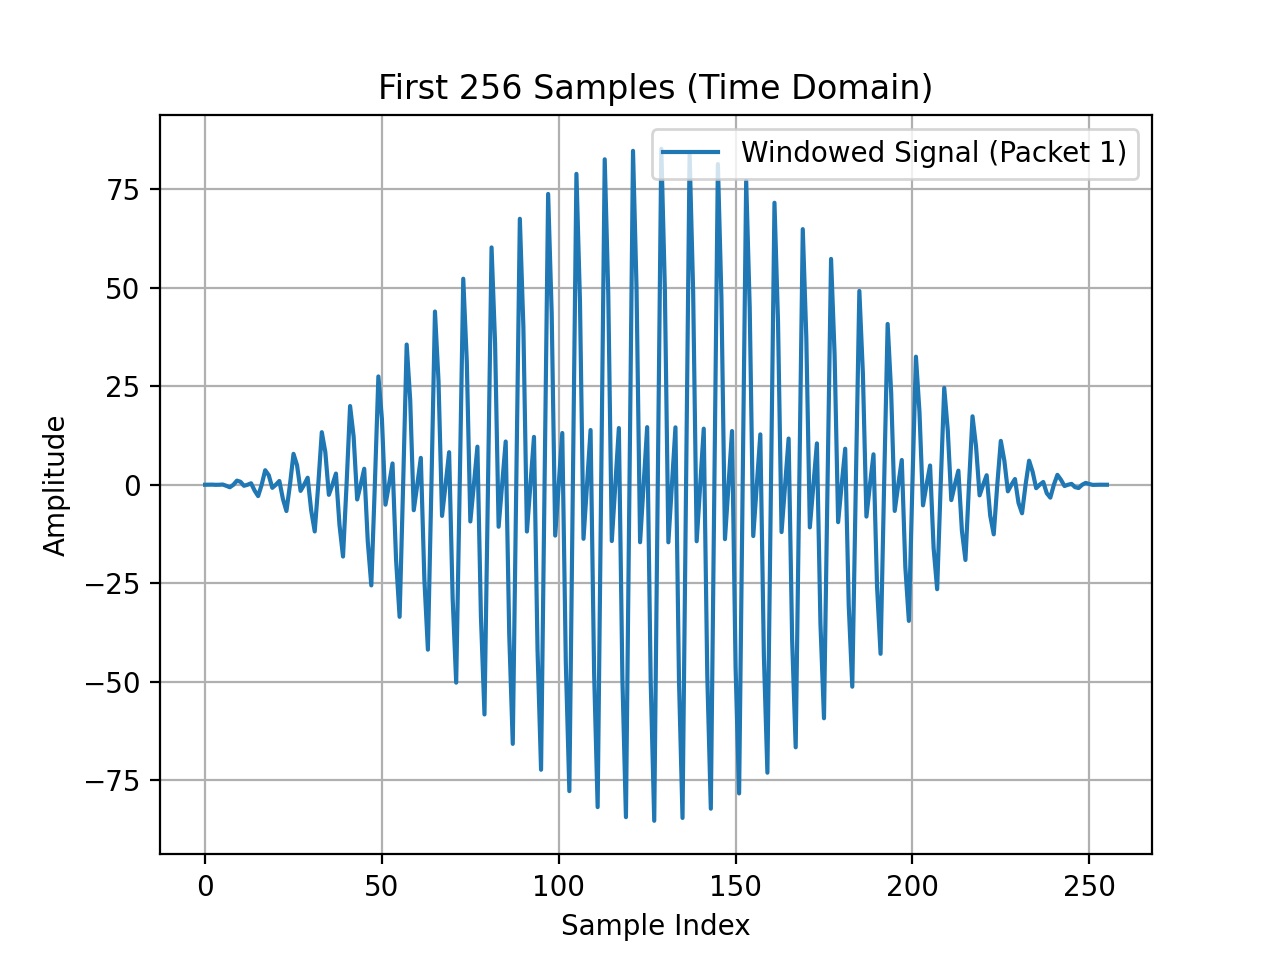

In [6]:
# Plot the first packet (256 samples) to verify windowing
plt.figure()
plt.plot(signal_windowed_flat[0:256].real, label='Windowed Signal (Packet 1)')
plt.title("First 256 Samples (Time Domain)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


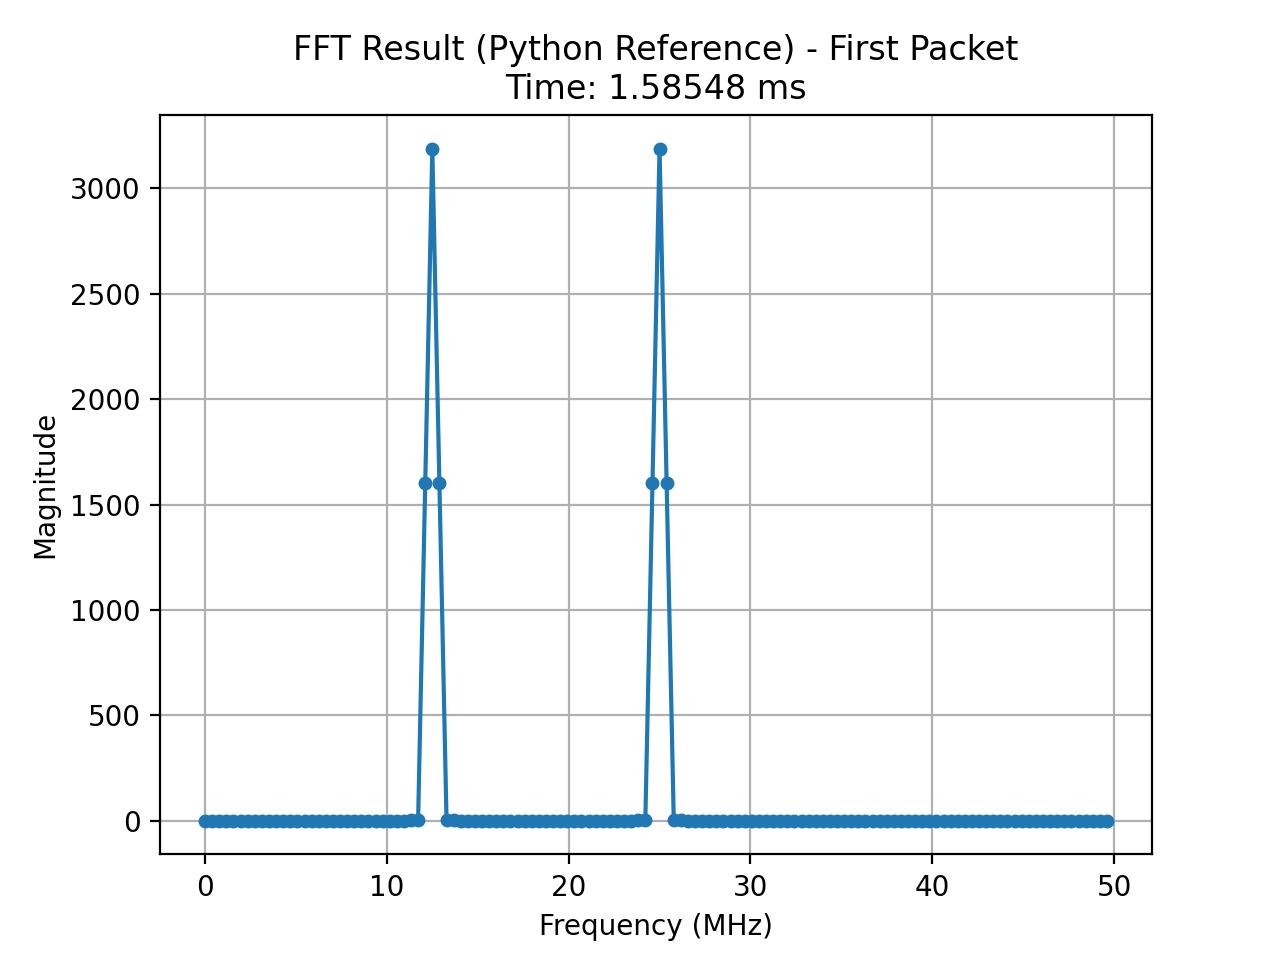

In [7]:
# ------------------------------------------------------------------
# 5. Visualization
# ------------------------------------------------------------------
# Calculate frequency axis
freqs = np.fft.fftfreq(fft_size, d=1/fs)
# Mask to keep only positive frequencies
mask = freqs >= 0
freqs_pos = freqs[mask] / 1e6  # Convert to MHz for plotting

# Get magnitude of the first packet for display
magnitude = np.abs(fft_output_python[0][mask])

plt.figure()
plt.plot(freqs_pos, magnitude, 'o-', markersize=4)
plt.title(f"FFT Result (Python Reference) - First Packet\nTime: {execution_time_ms:.5f} ms")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

In [8]:
from pynq import Overlay
from pynq import allocate

ol = Overlay("./overlays/fft.bit")

In [9]:
ol?

In [10]:
print(ol.ip_dict.keys())

dict_keys(['fft_0', 'axi_dma_0', 'processing_system7_0'])


In [11]:
fft = ol.fft_0
dma = ol.axi_dma_0

In [12]:
fft.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0)
}

In [13]:
dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

In [14]:
in_buffer = allocate(shape=(total_samples,), dtype=np.uint64)
out_buffer = allocate(shape=(total_samples,), dtype=np.uint64)

In [15]:
def float_to_q16_16(data_array):
    
    scaled = data_array * 65536.0
    
    max_val = (2**31 - 1)
    min_val = -(2**31)
    
    scaled = np.clip(np.round(scaled), min_val, max_val)
    
    return scaled.astype(np.int32)

In [16]:
signal_real = signal_windowed_flat
signal_imag = 0.0
signal_real_fixed = float_to_q16_16(signal_real)
signal_imag_fixed = float_to_q16_16(signal_imag)
signal_real_uint32 = signal_real_fixed.view(np.uint32)
signal_imag_uint32 = signal_imag_fixed.view(np.uint32)
packed_data = (signal_real_uint32.astype(np.uint64) << 32) | signal_imag_uint32.astype(np.uint64)

in_buffer[:] = packed_data

In [17]:
print(f"Buffer Allocated at Physical Address: {hex(in_buffer.device_address)}")
print(f"Total Samples: {len(in_buffer)}")
print(f"Data Type: {in_buffer.dtype}")
print(f"Buffer Allocated at Physical Address: {hex(out_buffer.device_address)}")
print(f"Data Type: {out_buffer.dtype}")

Buffer Allocated at Physical Address: 0x15849000
Total Samples: 256
Data Type: uint64
Buffer Allocated at Physical Address: 0x1584a000
Data Type: uint64


In [18]:
fft.write(0x00, 0x81)
fft.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0)
}

In [19]:
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
stop_time = time.time()
hw_exec_time = stop_time - start_time

print(f"HARDWARE FIR EXECUTION TIME: {hw_exec_time*1e3:.4f} ms")
print(f"SOFTWARE FIR EXECUTION TIME: {execution_time_ms:.4f} ms")
print(f"HARDWARE ACCELERATION FACTOR: {execution_time_ms / 1000 / hw_exec_time:.2f}")

HARDWARE FIR EXECUTION TIME: 2.9087 ms
SOFTWARE FIR EXECUTION TIME: 1.5855 ms
HARDWARE ACCELERATION FACTOR: 0.55


In [20]:
dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=1, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=1, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=361009152),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=2048),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=1, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGS

In [21]:
def q16_16_to_float(data_uint64):
    
    real_uint32 = (data_uint64 & 0xFFFFFFFF).astype(np.uint32)
    
    imag_uint32 = (data_uint64 >> 32).astype(np.uint32)
    
    real_int32 = real_uint32.astype(np.int32)
    imag_int32 = imag_uint32.astype(np.int32)
    
    real_float = real_int32 / 65536.0
    imag_float = imag_int32 / 65536.0
    
    return real_float, imag_float

<IPython.core.display.Javascript object>


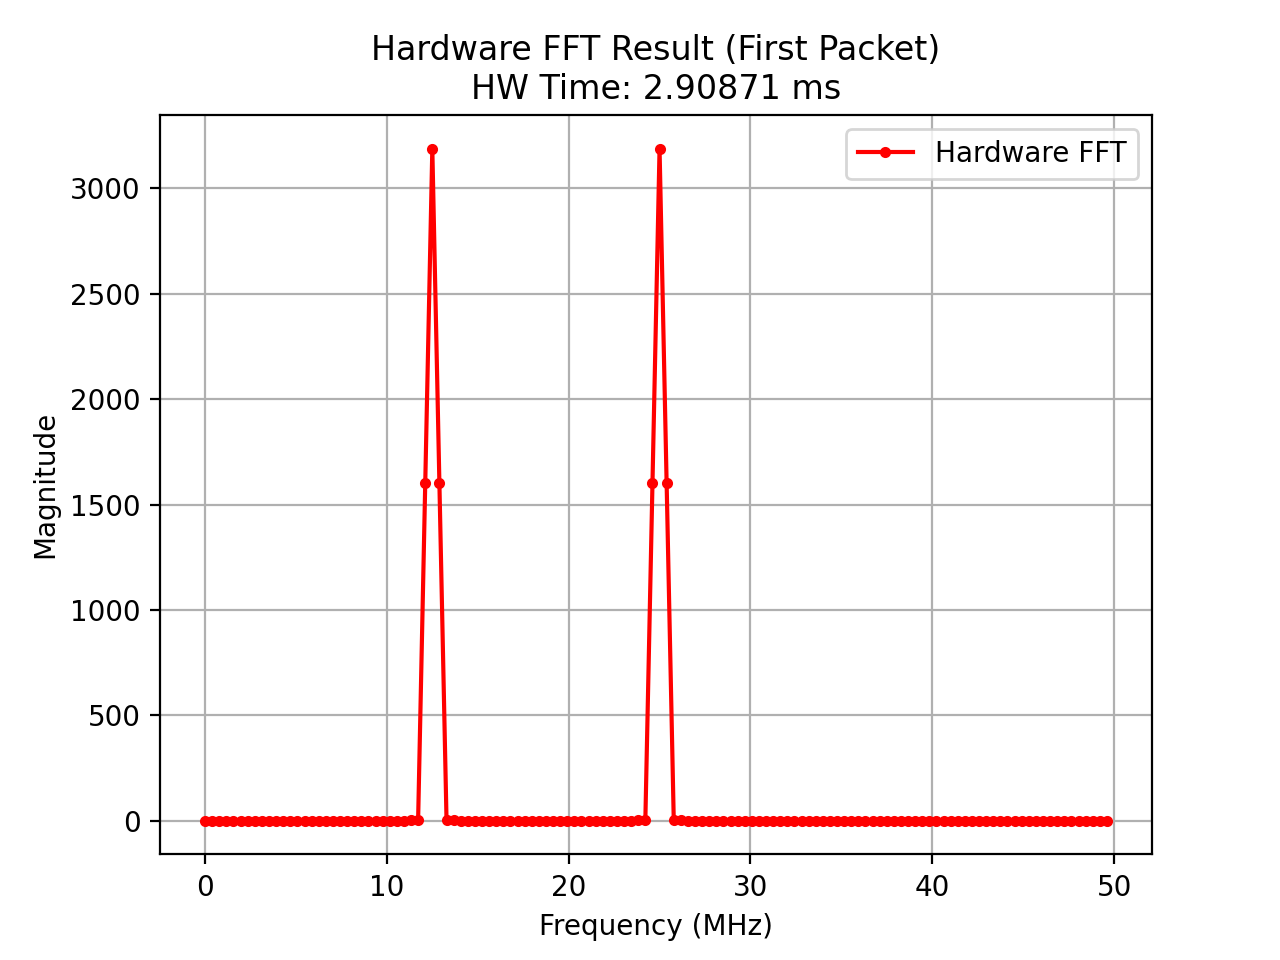

In [23]:
# ------------------------------------------------------------------
# 5. Visualization (Verify Result)
# ------------------------------------------------------------------
# 주파수 축 계산 (100MHz, 256 point)
freqs = np.fft.fftfreq(fft_size, d=1/fs)
mask = freqs >= 0
freqs_pos = freqs[mask] / 1e6

# 첫 번째 패킷(256 샘플)의 결과만 추출하여 플롯
out_real, out_imag = q16_16_to_float(out_buffer[mask])
magnitude_hw = np.sqrt(out_real**2 + out_imag**2)

plt.figure()
plt.plot(freqs_pos, magnitude_hw, 'r.-', label='Hardware FFT')
plt.title(f"Hardware FFT Result (First Packet)\nHW Time: {hw_exec_time*1e3:.5f} ms")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
print(len(out_buffer))
print(out_buffer)

256
[18446740427282317312 18446738649165855986 18446740414397415175
 18446740362857807500 18446740362857807395 18446739899001339171
 18446740268368526611 18446741389354990794 18446740212533951491
 18446739920476174984 18446740109454736029 18446740057915128272
 18446739903296305395 18446739306295850857 18446739675663038153
 18446740921203554081 18446739422259966944 18446736952653770649
 18446739061482713016 18446738868209183977 18446738524611799408
 18446737455164941382 18446737760107618089 18446739521044207551
 18446736600466443338 18446735359220890263 18446734680616051455
 18446733246096963736 18446730471548069822 18446724132176292214
 18446712956671215795     5540160024543124 18446737201552982449
 18441218456654377899       26972394342353       14057427855814
        9431748126180        7941394495323        5201205370903
        3075196565621        3156800948281        2602750169898
        1881195665845        1378684493496         936302862921
         704374629594         219043

In [23]:
del in_buffer, out_buffer